# 因果性の検証

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy import linalg

## データの取得

In [2]:
macro_data = sm.datasets.macrodata.load_pandas().data

In [3]:
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


## データの加工

In [4]:
macro_data['year'] = macro_data['year'].astype(int)

macro_data.index = pd.date_range(
    str(macro_data['year'].min()), 
    periods=len(macro_data), 
    freq='Q'
)
columns = ['realgdp', 'realcons', 'realinv']
target_data = macro_data[columns].copy()

target_data = np.log(target_data) - np.log(target_data.shift(1))
target_data.dropna(inplace=True)
target_data *= 100

In [5]:
target_data.head()

,realgdp,realcons,realinv
1959-06-30,2.494213,1.528611,8.021268
1959-09-30,-0.119295,1.038598,-7.213104
1959-12-31,0.349453,0.108401,3.442511
1960-03-31,2.219018,0.953415,10.266377
1960-06-30,-0.468455,1.257243,-10.669385


## VARモデルの構築

In [6]:
model = VAR(target_data)
model_result = model.fit(maxlags=15, ic='aic')
model_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 06, Dec, 2020
Time:                     18:26:57
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.205328
Nobs:                     199.000    HQIC:                -0.0902127
Log likelihood:          -788.137    FPE:                   0.747593
AIC:                    -0.291150    Det(Omega_mle):        0.645336
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.128149         0.129527            0.989           0.322
L1.realgdp         -0.286148         0.171582           -1.668           0.095
L1.realcons         0.673869         0.132245            5.096    

## グレンジャー因果の実装

In [7]:
result = []
for colname_to in columns:
    for colname_from in columns:
        
        test_result = model_result.test_causality(colname_to, colname_from, kind='f')
        print(test_result.summary())
        result.append([
            test_result.causing[0], test_result.caused[0], 
            test_result.test_statistic, test_result.pvalue,
            '*' if test_result.pvalue <= 0.05 else ''
        ])
result = pd.DataFrame(result, columns=['causing', 'caused', 't_value', 'p_value', 'flag'])
result['p_value'] = result['p_value'].apply(lambda x: np.round(x, 2))
result = result.sort_values('p_value')

Granger causality F-test. H_0: realgdp does not Granger-cause realgdp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.323          2.621   0.266 (3, 567)
----------------------------------------------
Granger causality F-test. H_0: realcons does not Granger-cause realgdp. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         11.97          2.621   0.000 (3, 567)
----------------------------------------------
Granger causality F-test. H_0: realinv does not Granger-cause realgdp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.5631          2.621   0.640 (3, 567)
----------------------------------------------
Granger causality F-test. H_0: realgdp does not Granger-cau

In [8]:
result

,causing,caused,t_value,p_value,flag
1,realcons,realgdp,11.968514,0.00,*
4,realcons,realcons,7.390178,0.00,*
7,realcons,realinv,14.665689,0.00,*
3,realgdp,realcons,2.450067,0.06,
5,realinv,realcons,1.650771,0.18,
6,realgdp,realinv,1.561868,0.20,
0,realgdp,realgdp,1.322876,0.27,
8,realinv,realinv,0.951465,0.42,
2,realinv,realgdp,0.563124,0.64,


## インパルス応答関数の実装

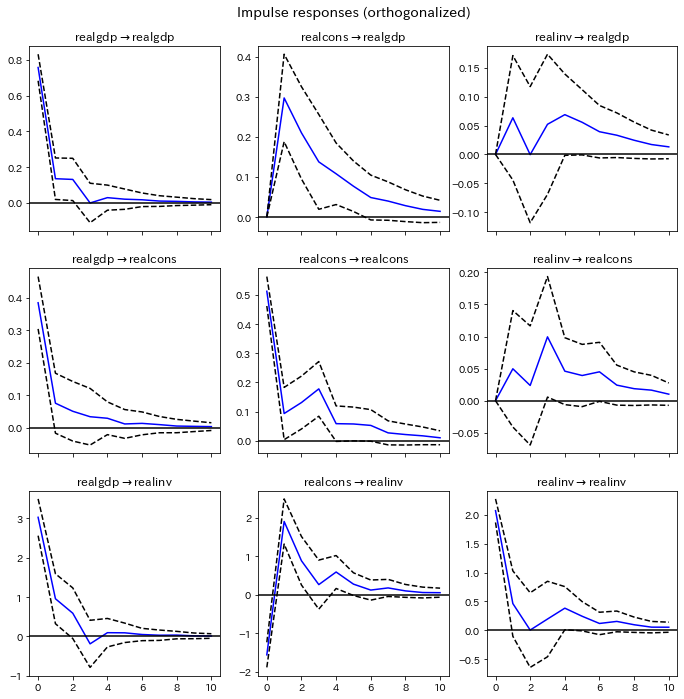

In [ ]:
irf = model_result.irf(10)
irf.plot(orth=True)

### 新撹乱項の標準偏差を求める

In [ ]:
sigma = model_result.sigma_u

L = np.linalg.cholesky(sigma)
L_inv = np.linalg.inv(L)
L_t_inv = np.linalg.inv(L.T)
D = L_inv * sigma * L_t_inv

new_sigma_sqrt = np.sqrt(np.diag(D))
new_sigma_sqrt